In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import torch
import torchio as tio
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path

dir2 = os.path.abspath('..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

In [98]:
X = np.load('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\vqgan-model1024-embedding-weight.npy')
n_samples, n_features = X.shape
n_neighbors = 30
n_samples, n_features
n_components = 16

In [112]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title, ax, dim1=0, dim2=1):
    X = MinMaxScaler().fit_transform(X)

    ax.scatter(X[:, dim1], X[:, dim2])

    ax.set_title(title)
    #ax.axis("off")

In [99]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    Isomap,
    LocallyLinearEmbedding,
    MDS,
    SpectralEmbedding,
    TSNE,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=n_components, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=n_components),
    #"Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
    #    n_components=n_components
    #),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=n_components),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=n_components, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=n_components, method="modified"
    ),
    #"Hessian LLE embedding": LocallyLinearEmbedding(
    #    n_neighbors=n_neighbors, n_components=2, method="hessian"
    #),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=n_components, method="ltsa"
    ),
    "MDS embedding": MDS(n_components=n_components, n_init=1, max_iter=100),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=n_components),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=n_components, random_state=0, eigen_solver="arpack"
    ),
    #"t-SNE embedding": TSNE(
    #    n_components=n_components, #init="pca", learning_rate="auto", random_state=0
    #),
    #"NCA embedding": NeighborhoodComponentsAnalysis(
    #    n_components=n_components, init="random", random_state=0
    #),
}

In [100]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...
Computing Random Trees embedding...
Computing Spectral embedding...


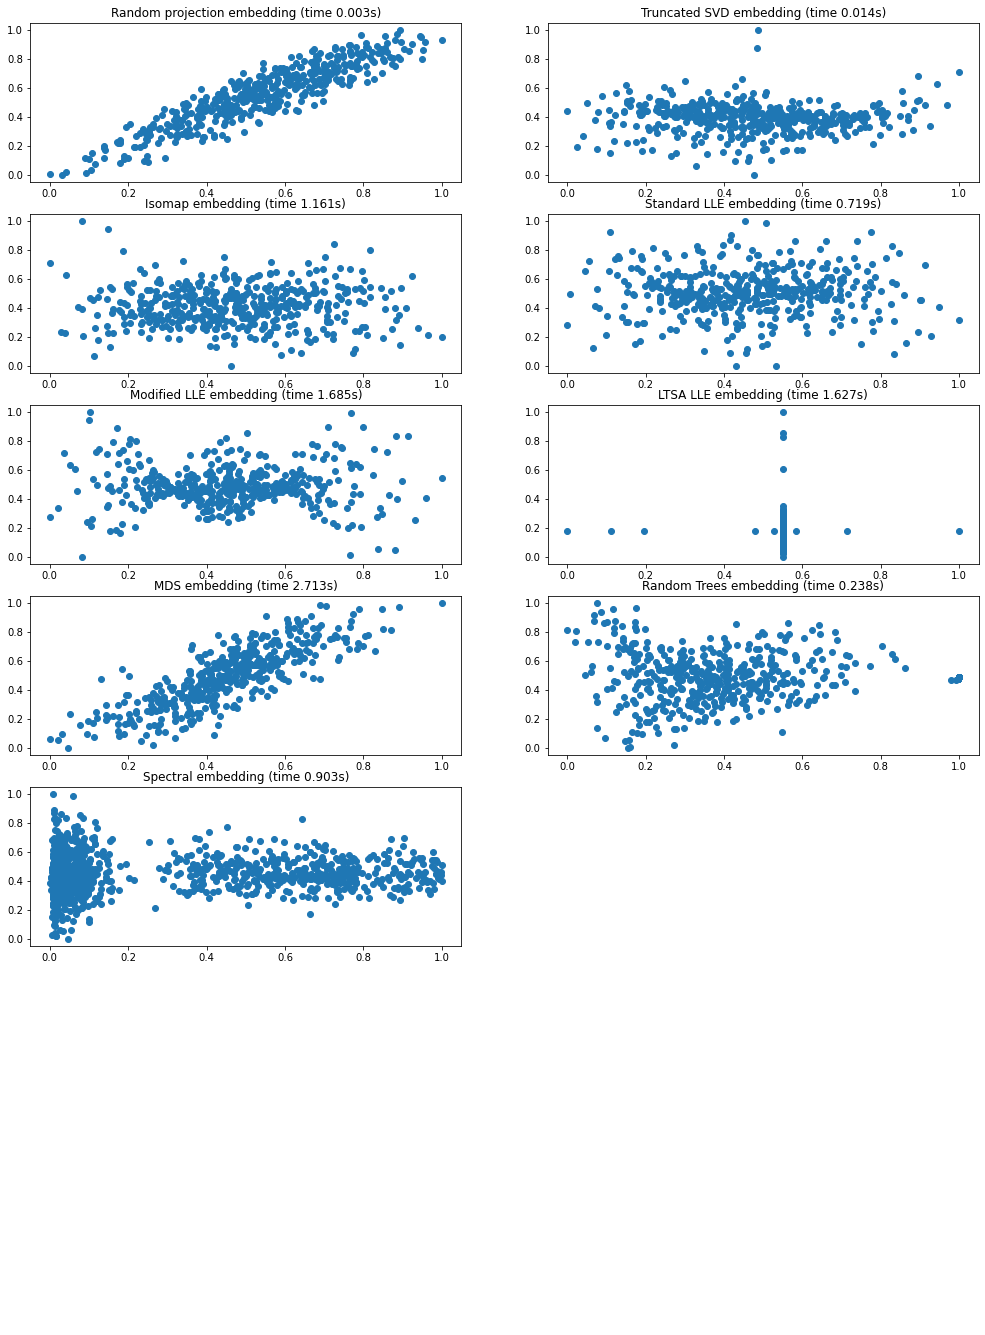

In [101]:
from itertools import zip_longest

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(17, 24))

for name, ax in zip_longest(timing, axs.ravel()):
    if name is None:
        ax.axis("off")
        continue
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title, ax)

plt.show()

In [115]:

from ipywidgets import interact

@interact(i=(0, n_components-1), j=(0, n_components-1))
def show(i, j):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    plot_embedding(projections["Spectral embedding"], title, ax, dim1=i, dim2=j)
    plt.show()

interactive(children=(IntSlider(value=7, description='i', max=15), IntSlider(value=7, description='j', max=15)…

In [103]:
from pathlib import Path

out_folder = Path('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\vqgan-embeddings') / f'ndim-{n_components}'
out_folder.mkdir(parents=True, exist_ok=True)

for k, v in projections.items():
    k = k.replace(' ', '-').lower()
    print(k, v.shape, v.mean(), v.std())
    np.save(out_folder / f'{k}.npy', v)

random-projection-embedding (1024, 16) -0.0182592310687201 2.0944719192914643
truncated-svd-embedding (1024, 16) 0.00842842 2.1625693
isomap-embedding (1024, 16) -3.993116601264113e-16 2.439206536982807
standard-lle-embedding (1024, 16) 4.748844140188904e-14 0.03125
modified-lle-embedding (1024, 16) -8.604838304566986e-17 0.031249999999999997
ltsa-lle-embedding (1024, 16) 0.002661230617871594 0.031136479434876747
mds-embedding (1024, 16) -3.2959746043559335e-17 2.16127853206657
random-trees-embedding (1024, 16) 0.7459553218881381 3.134729659599811
spectral-embedding (1024, 16) 4.183956476673856e-05 0.0033076023788794207


In [176]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from joblib import dump, load

out_folder = Path('X:\\Datasets\\Deep-Image-Reconstruction\\derivatives\\vqgan-pca')

pca = {}
for pca_components in (2, 4, 8, 16, 32, 64, 128):
    pca[pca_components] = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca_components)),
    ])
    pca[pca_components].fit(X)
    pickle.dump(pca[pca_components], open(out_folder / f'pca-{pca_components}dim-sklearn.pkl', 'wb'))
    
    

In [147]:
pca.__dict__.keys()

dict_keys(['n_components', 'copy', 'whiten', 'svd_solver', 'tol', 'iterated_power', 'random_state', 'n_features_in_', '_fit_svd_solver', 'mean_', 'n_samples_', 'n_features_', 'components_', 'n_components_', 'explained_variance_', 'explained_variance_ratio_', 'singular_values_', 'noise_variance_'])

In [164]:
np.set_printoptions(suppress=True)
pca[4].explained_variance_ratio_.sum()

0.99158275

In [131]:
from ipywidgets import interact


@interact(i=(0, pca_components-1), j=(0, pca_components-1))
def show(i, j):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
    plt.scatter(principalComponents[:, i], principalComponents[:, j])
    plt.show()


interactive(children=(IntSlider(value=3, description='i', max=7), IntSlider(value=3, description='j', max=7), …